# Exploratory Data Analysis

querying our MongoDB database:
- filtering data based on project id
- using aggregation pipeline to group data and sort by date and get the sum of commits for each date,
- converting the JSON_like document result into a pandas dataframe,
- drop NaN values from dataframe
- plot a line plot using matplotlib
    
  
## Summary

The database contains data for many Apache Projects. For your group projects, only the following 39 projects are relevant:
- ant-ivy, archiva, calcite, cayenne, commons-bcel, commons-beanutils, commons-codec, commons-collections, commons-compress, commons-configuration, commons-dbcp, commons-digester, commons-io, commons-jcs, commons-jexl, commons-lang, commons-math, commons-net, commons-rdf, commons-scxml, commons-validator, commons-vfs, deltaspike, eagle, giraph, gora, jspwiki, kylin, lens, mahout, manifoldcf, nutch, opennlp, parquet-mr, santuario-java, systemml, tika, wss4j

Your task is to develop an automated model for clustering project popularity over time. The model should be designed so that it can be used on GitHub, for example, to showcase trending or popular projects for a specific period of time. How many labels are useful for clustering depends on your decision. 

You have to frame these questions into an analytic problem. Then, you have to create models that can be used to answer the questions. You have to choose appropriate features from the available data for this and decide which kind of analytic approach to use. Finally, you have to evaluate how well your approach performs. 



### Accessing the database with Python

You can use the [pycoSHARK](https://github.com/smartshark/pycoshark) library for accessing the MongoDB. The pycoSHARK provides an ORM layer based on the mongoengine library. Alternatively, you can also access the database with native MongoDB queries using the [pymongo](https://api.mongodb.com/python/current/) API. 

The code below shows how to use the database with the pycoSHARK. 

In [2]:
# code for installing our own library for accessing the MongoDB through a ORM engine
import sys
!{sys.executable} -m pip install pycoshark

  Using cached pycoSHARK-1.4.2-py3-none-any.whl
  Using cached mongoengine-0.23.1-py3-none-any.whl (107 kB)
  Using cached pymongo-3.11.4-cp38-cp38-manylinux2014_x86_64.whl (531 kB)


In [201]:
from mongoengine import connect
from pycoshark.mongomodels import People, Commit, Project, VCSSystem
from pycoshark.utils import create_mongodb_uri_string
import pandas as pd
import numpy as np

# Database credentials
user = 'datascience2021'
password = '43QAt5bd91'
host = '134.76.81.151'
port = '27017'
authentication_db = 'smartshark'
database = "smartshark"
ssl_enabled = None

# Establish connection
uri = create_mongodb_uri_string(user, password, host, port, authentication_db, ssl_enabled)
connect(database, host=uri)

# Fetch project id and version control system id for the 'kafka' project
# The only() decides the data that is actually retrieved from the MongoDB. Always restrict this to the field that you require!
project = Project.objects(name='giraph').only('id').get()
vcs_system = VCSSystem.objects(project_id=project.id).only('id','url').get()
print('url of VCS system of the project: %s' % vcs_system.url)

# determine latest commit of the commons-math project
last_commit = None
max_date = None
# get commits by a period of time
commits_by_month = None
# loop over all commits of kafka
for commit in Commit.objects(vcs_system_id=vcs_system.id).only('committer_date', 'committer_id','revision_hash').timeout(False):
    if max_date is None:
        last_commit = commit
        max_date = commit.committer_date
    if max_date<commit.committer_date:
        last_commit = commit
        max_date = commit.committer_date
        
print('revision hash of last commit in database: %s' % last_commit.revision_hash)
print('date of last commit in database: %s' % last_commit.committer_date)
print('link to commit on Github: https://github.com/apache/commons-math/commit/%s' % last_commit.revision_hash)

# fetch committer from People
last_committer = People.objects(id=last_commit.committer_id).only('name','email').get()
print('last commit by %s %s (%s)' % (last_committer.id, last_committer.name,last_committer.email))

# We can now fetch the commits and analyze them
#num_commits = Commit.objects(vcs_system_id=vcs_system.id).aggregate()
num_commits = Commit.objects(vcs_system_id=vcs_system.id).count( )

print('Number of commits:', num_commits)
project_name = Project.objects.filter(name = 'giraph').get().name


url of VCS system of the project: https://github.com/apache/giraph.git
revision hash of last commit in database: d41221966cece5ed8c029a7e941b5d621486ddb1
date of last commit in database: 2018-11-09 19:42:35
link to commit on Github: https://github.com/apache/commons-math/commit/d41221966cece5ed8c029a7e941b5d621486ddb1
last commit by 5bf51c32d2f8190d85f3bae5 Maja Kabiljo (majakabiljo@fb.com)
Number of commits: 1121


In [202]:
# project name is implied in this filter(vcs_system has already have the project id)
Commit.objects.filter(vcs_system_id=vcs_system.id).count()

1121

In [209]:

pipeline = [
   
 {
     "$group" : {
       "_id": {
            "year": { "$year" : "$committer_date" },        
            "month": { "$month" : "$committer_date" },
            #"day": { "$dayOfMonth" : "$committer_date" },
        },
        "count": {"$sum": 1 }
  
 }},
    {
         "$sort":
                   {"count":-1}
      }
    ]
cur = Commit.objects.filter(vcs_system_id=vcs_system.id).aggregate(pipeline)

#print(list(cur))



In [210]:
data = list(cur)

df = pd.json_normalize(data)
df = df.dropna()

In [211]:
cols=["_id.year","_id.month"]
df['date'] = df[cols].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")

In [212]:

df['date'] = pd.to_datetime(df['date'])
df['year'], df['month'] = df['date'].dt.year, df['date'].dt.month
df = df.sort_values("date")
df.drop(['_id.year', '_id.month'], axis = 1, inplace=True)
df

count       date  year  month
74      3 2010-10-01  2010     10
7      29 2010-11-01  2010     11
13     22 2010-12-01  2010     12
40     11 2011-01-01  2011      1
43     10 2011-02-01  2011      2
..    ...        ...   ...    ...
90      1 2018-07-01  2018      7
91      1 2018-08-01  2018      8
71      3 2018-09-01  2018      9
66      4 2018-10-01  2018     10
82      2 2018-11-01  2018     11

[94 rows x 4 columns]

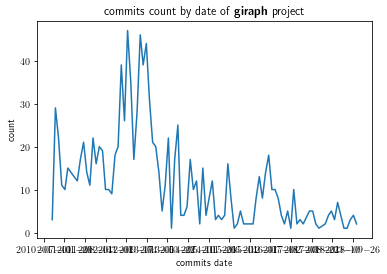

None


In [213]:
import matplotlib.pyplot as plt
import datetime
import numpy as np
from matplotlib.ticker import MaxNLocator
from matplotlib import rc
rc('text', usetex=True)

fig,axes=plt.subplots(1,1)

axes.plot(df["date"],df["count"])
axes.xaxis.set_major_locator(MaxNLocator(20)) 
axes.set_title("commits count by date of "+ r"\textbf{" + str(project_name) + "}"+ " project")
axes.set_xlabel("commits date")
axes.set_ylabel("count")

plt.show()
print(project.name)

In [198]:
df.shape

(94, 4)